In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

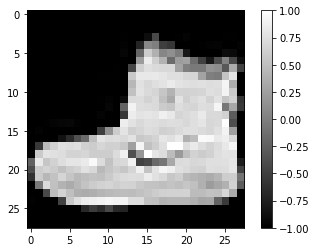

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

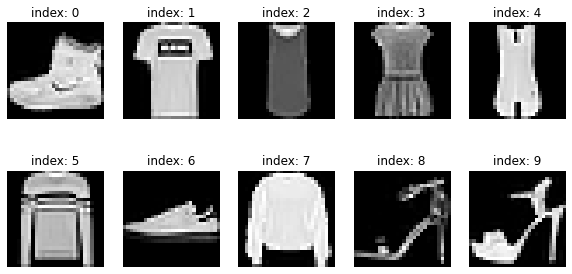

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

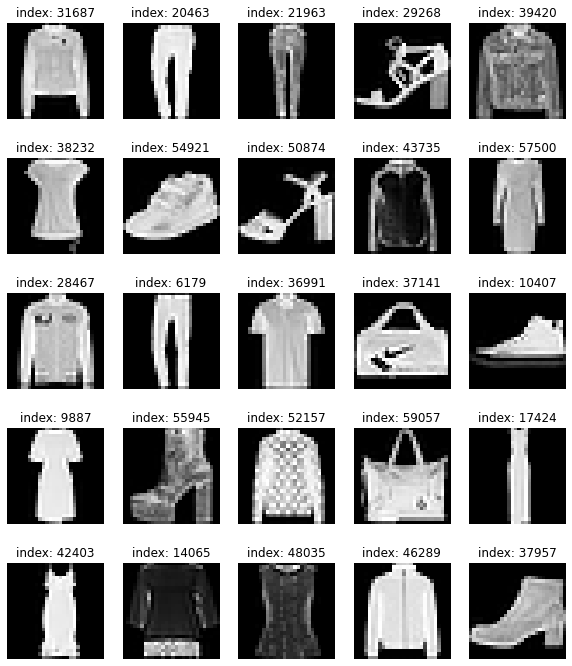

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model(): # make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록 했습니다.

    # Start
    model = tf.keras.Sequential() # 함수 내부에서는 먼저 tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아줍니다.

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다.
    model.add(layers.LeakyReLU())  # 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였습니다

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer ; 여기에서 가장 중요한 레이어는 바로 Conv2DTranspose 레이어입니다. Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층입니다. 
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer ; 이 모델에서는 세 번의 Conv2DTranspose 층을 이용해 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나갑니다
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh')) # 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

    return model

In [13]:
#  생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력해 봅시다.

generator = make_generator_model()

generator.summary()

# 처음 입력된 벡터는 어떤 레이어를 지나며, 첫 레이어를 지난 후의 shape는 어떤 형태입니까?
# 입력된 (batch_size, 100) 벡터는 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어를 거치며 (batch_size, 12544) 형상의 벡터가 됩니다.

# 첫 번째 레이어를 지난 후 벡터는 어떤 층을 지나게 됩니까? 이 레이어는 왜 필요합니까?
# 첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.
# 이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환시키는 작업입니다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
noise = tf.random.normal([1, 100]) # tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.

In [15]:
generated_image = generator(noise, training=False) # 단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다
generated_image.shape

TensorShape([1, 28, 28, 1])

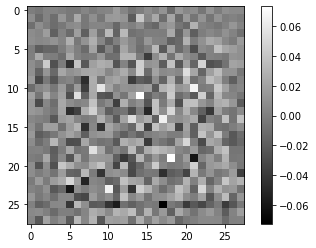

In [16]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [17]:
def make_discriminator_model():  # 판별자 또한 make_discriminator_model 함수로 구현하였습니다.

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))  # Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    # 첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지 줄어들게 됩니다.

    # Third: Flatten Layer
    model.add(layers.Flatten()) 
    # 마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환합니다.
    # (이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다)

    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    #  1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다

    return model

In [18]:
# 그럼 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력해 봅시다.

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
# 그렇다면 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까요? 바로 확인해 봅시다.

decision = discriminator(generated_image, training=False)
decision

# 텐서플로우의 텐서 형태로 출력이 되었습니다. 이 값 또한 아직은 아무런 의미가 없는 값일 것입니다.

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0049431]], dtype=float32)>

# 10-11. 생성 모델이 똑똑해지기 위한 기나긴 여정 

(1) 손실함수와 최적화 함수

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)


그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?

바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.

### generator_loss

In [21]:
# 그러면 generator_loss는 다음과 같이 구현할 수 있겠군요.
# generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

### discriminator_loss

In [22]:
def discriminator_loss(real_output, fake_output):  # 반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!
    total_loss = real_loss + fake_loss
    return total_loss  # 최종 discriminator_loss 값은 이 둘을 더한 값입니다.

### discriminator accuracy

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)

In [24]:
# 자.. 그럼 손실함수는 모두 설계가 되었고, 이제 최적화 함수를 설정할 차례입니다. 이번에는 Adam 최적화 기법 을 활용해 보겠습니다.


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
# 중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.


discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 10-12. 생성 모델이 똑똑해지기 위한 기나긴 여정 

(2) 훈련과정 설계

In [26]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [27]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
                # 학습시킬 훈련 함수 위에 @tf.function 이라는 데코레이터를 붙여서 사용합니다. 이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해줍니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [28]:
@tf.function
def train_step(images):  #(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈:는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
        generated_images = generator(noise, training=True)  #(4) generated_images 생성: generator가 noise를 입력받은 후 generated_images 생성

        #(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산: fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값: 이번 스텝에 계산된 loss와 accuracy를 리턴

# 이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

In [29]:
# model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화해주는 과정이 담겨 있는데, 어딘가 익숙하지 않나요?

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 바로 우리가 위에서 해봤던, subplot을 이용해서 총 16개의 sample을 시각화하는 과정입니다. 16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화하는 것이죠.
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    # 또한, plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장합니다.

    plt.show()

In [30]:
# 학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없겠습니다. GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다.

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints' # checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용하겠습니다.

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
            # tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
            # 모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적입니다. 아주 오랜 시간 동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 테니까요..!
            # checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장합니다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

# 10-13. 생성 모델이 똑똑해지기 위한 기나긴 여정 

(3) 학습 시키기

In [32]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [33]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

NameError: in user code:

    /tmp/ipykernel_31/3900794168.py:13 train_step  *
        gen_loss = generator_loss(fake_output)
    /tmp/ipykernel_31/4007509632.py:5 generator_loss  *
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    NameError: name 'cross_entropy' is not defined


In [35]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1082829 Feb 17 16:02 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
